# Algoritmo de Canny

O Canny Edge Detector é um algoritmo usado para realizar a detecção de bordas no processamento de imagens. É considerado um dos algoritmos que entregam o melhor resultado na detecção de bordas, devido aos diversos refinamentos realizados através de suas etapas. O algoritmo implementado e descrito neste documento foi fortemente baseado no conteúdo teórico exposto no livro "Digital Image Processing", de Rafael Gonzalez e Richard Woods.

## Etapas Iniciais

Inicialmente, são importadas as dependências externas que serão necessárias.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import pi

A imagem de entrada é carregada. Devido ao fato do `OpenCV` trabalhar com as imagens no formato BGR, é necessário converter a imagem para RGB antes de exibi-la através do `Matplotlib`.

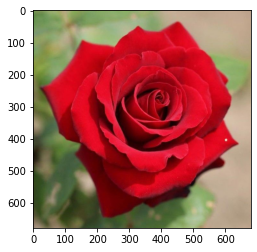

In [2]:
input_img = cv2.imread('../input/rose-flower.png')

plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))


É necessário converter a imagem de entrada para a escala de cores cinza, para ser possível realizar o processamento e detecção de bordas. Além disso, a função `plot_grayscale_img` é declarada, sendo que ela será utilizada para a exibição de imagens de escala de cores cinza.

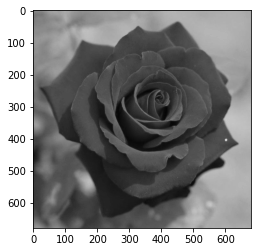

In [3]:
def plot_grayscale_img(img):
  plt.imshow(img, cmap='gray', vmin=0, vmax=255)

gray_input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
(img_height, img_width) = gray_input_img.shape

plot_grayscale_img(gray_input_img)

## Aplicador de Kernels

Para a aplicação das matrizes de kernel, utilizadas em processos de convolução ao longo do algoritmo, foi implementada a classe `KernelApplier`. Abaixo é importada uma função utilitária que facilita a utilização da classe. Não será detalhada a implementação dessa classe, já que não é o intuito do atual documento. Entretanto, o conceito por trás de sua implementação é bem simples, caracterizando-se como um método iterativo que percorre toda uma matriz bidimensional, aplicando uma matriz de kernel e gerando uma nova matriz de mesmas dimensões da inicial.

In [4]:
import sys
sys.path.append('../')

from src.kernel import apply_kernel_to_matrix


## Implementação do Algoritmo

A primeira etapa do algoritmo de Canny é suavizar a imagem para remover detalhes desnecessários e facilitar a detecção de bordas. Isso é realizado através da aplicação de um kernel 5x5 gaussiano.

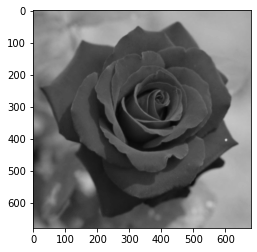

In [5]:
GAUSSIAN_KERNEL_5 = np.array([[1,  4,  7,  4, 1],
                              [4, 16, 26, 16, 4],
                              [7, 26, 41, 26, 7],
                              [4, 16, 26, 16, 4],
                              [1,  4,  7,  4, 1]]) / 273

smoothed_img = apply_kernel_to_matrix(GAUSSIAN_KERNEL_5, gray_input_img)

plot_grayscale_img(smoothed_img)

A segunda etapa é calcular os valores relacionados aos gradientes da imagem. Primeiro é calculado o gradiente horizontal (eixo X) e o gradiente vertical (eixo Y), utilizando as matrizes de Sobel. Após isso, é calculada a magnitude do gradiente. E, por fim, é calculado a direção (ângulo) do gradiente.

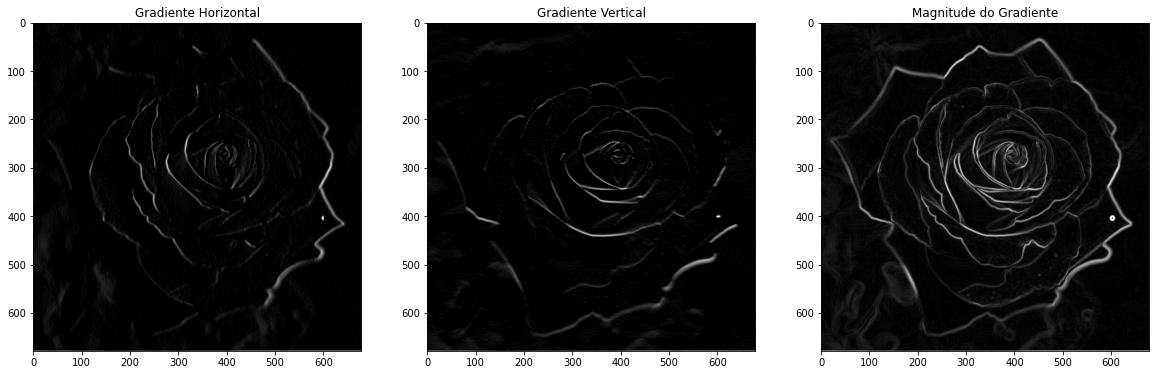

In [6]:
SOBEL_KERNEL_X = np.array([[-1,  0,  1],
                           [-2,  0,  2], 
                           [-1,  0,  1]])

SOBEL_KERNEL_Y = np.array([[-1, -2, -1],
                           [ 0,  0,  0], 
                           [ 1,  2,  1]])

gradient_x = apply_kernel_to_matrix(SOBEL_KERNEL_X, smoothed_img)
gradient_y = apply_kernel_to_matrix(SOBEL_KERNEL_Y, smoothed_img)

gradient_magnitude = np.sqrt(np.power(gradient_x, 2) + np.power(gradient_y, 2))

gradient_direction_in_radians = np.arctan2(gradient_y, gradient_x)
gradient_direction_in_degrees = gradient_direction_in_radians * 180 / pi
gradient_direction = gradient_direction_in_degrees

plt.figure(figsize=[20, 20])
plt.subplot(131)
plt.title('Gradiente Horizontal')
plot_grayscale_img(gradient_x)
plt.subplot(132)
plt.title('Gradiente Vertical')
plot_grayscale_img(gradient_y)
plt.subplot(133)
plt.title('Magnitude do Gradiente')
plot_grayscale_img(gradient_magnitude)


A terceira etapa é aplicar a supressão de não máximos (*non-maximum suppression*), para afinar as bordas que encontram-se largas. A função `get_edge_orientation` determina qual a orientação da borda, levando em consideração o ângulo obtido na etapa anterior e que uma mesma borda pode ter duas orientações distintas. Já a função `does_the_magnitude_value_must_be_suppressed` determina se o valor de magnitude analisado no momento deve ser suprimido ou não.

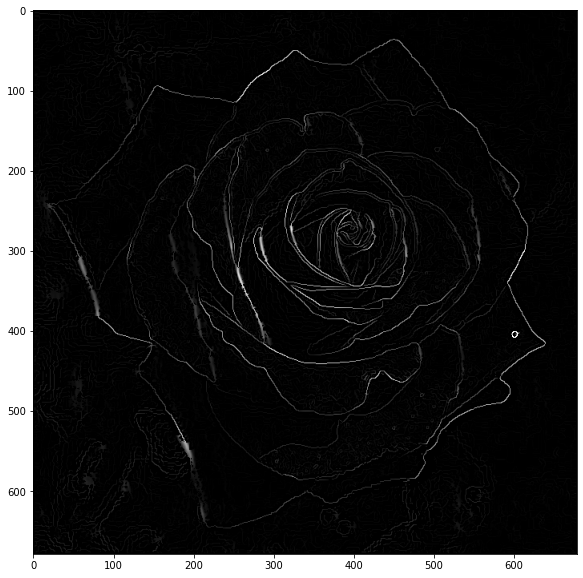

In [7]:
def get_edge_orientation(edge_angle):
  if edge_angle >= 180:
    return 'horizontal'
  if edge_angle < 157.5 and edge_angle >= 112.5:
    return '+45'
  if edge_angle < 112.5 and edge_angle >= 67.5:
    return 'vertical'
  if edge_angle < 67.5 and edge_angle >= 22.5:
    return '-45'
  if edge_angle < 22.5 and edge_angle >= -22.5:
    return 'horizontal'
  if edge_angle < -22.5 and edge_angle >= -67.5:
    return '+45'
  if edge_angle < -67.5 and edge_angle >= -112.5:
    return 'vertical'
  if edge_angle < -112.5 and edge_angle >= -157.5:
    return '-45'
  if edge_angle < -157.5:
    return 'horizontal'

def does_the_magnitude_value_must_be_suppressed(row, column):    
  is_the_extreme_horizontal_border = (column + 1 >= img_width) or (column - 1 <= 0)
  is_the_extreme_vertical_border = (row + 1 >= img_height) or (row - 1 <= 0)

  if is_the_extreme_horizontal_border or is_the_extreme_vertical_border:
    return True

  current_edge_angle = gradient_direction[row, column]
  current_edge_orientation = get_edge_orientation(current_edge_angle)
  current_mag = gradient_magnitude[row, column]
  
  if current_edge_orientation == 'horizontal':
    if current_mag < gradient_magnitude[row, column - 1] or current_mag < gradient_magnitude[row, column + 1]:
      return True
  elif current_edge_orientation == 'vertical':
    if current_mag < gradient_magnitude[row - 1, column] or current_mag < gradient_magnitude[row + 1, column]:
      return True
  elif current_edge_orientation == '+45':
    if current_mag < gradient_magnitude[row - 1, column + 1] or current_mag < gradient_magnitude[row + 1, column - 1]:
      return True
  elif current_edge_orientation == '-45':
    if current_mag < gradient_magnitude[row - 1, column - 1] or current_mag < gradient_magnitude[row + 1, column + 1]:
      return True

  return False

nonmaximum_suppressed_img = np.zeros(gray_input_img.shape)

for row in range(img_height):
  for column in range(img_width):
    if not does_the_magnitude_value_must_be_suppressed(row, column):
      nonmaximum_suppressed_img[row, column] = gradient_magnitude[row, column]

plt.figure(figsize=[10, 10])
plot_grayscale_img(nonmaximum_suppressed_img)

A quarta e última etapa é realizar a limiarização por histerese e análise de conectividade para detecção e conexão de bordas. Para a imagem em questão, os melhores valores encontrados para o limiar baixo e para o limiar alto foram 20 e 40, respectivamente.

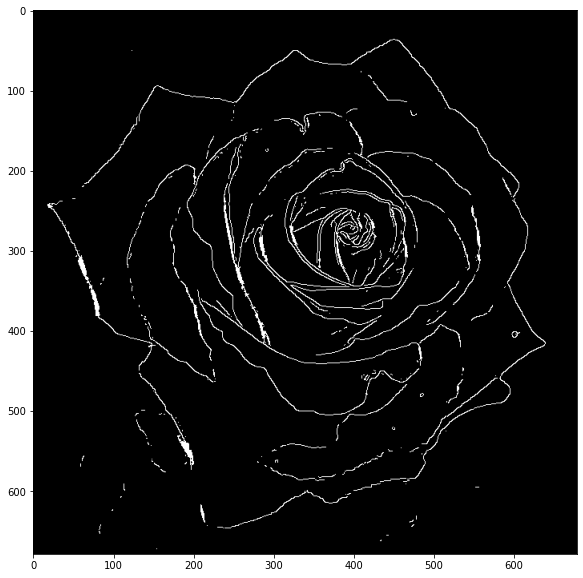

In [8]:
def apply_threshold(img, threshold_value):
  thresholded_img = np.copy(img)
  thresholded_img[thresholded_img <= threshold_value] = 0
  thresholded_img[thresholded_img > threshold_value] = 255
  return thresholded_img

low_threshold_img = apply_threshold(nonmaximum_suppressed_img, 20)
high_threshold_img = apply_threshold(nonmaximum_suppressed_img, 40)

low_threshold_img -= high_threshold_img

edges_pixels_coords = np.transpose(np.nonzero(high_threshold_img))
valid_edge_pixels = np.full(gray_input_img.shape, False)

for edge_pixel_coords in edges_pixels_coords:
  for row_index in range(edge_pixel_coords[0], 3):
    for column_index in range(edge_pixel_coords[1], 3):
      if low_threshold_img[row_index, column_index] != 0:
        valid_edge_pixels[row_index, column_index] = True

thresholded_img = np.where(valid_edge_pixels == False, high_threshold_img, low_threshold_img)

plt.figure(figsize=[10, 10])
plot_grayscale_img(thresholded_img)